# Analyzing the topic changes and their implications

First, we load the pretrained topic model and the vectors

In [2]:
import numpy as np
from tqdm import tqdm
import sqlite3
import pandas as pd
from collections import defaultdict
from bertopic import BERTopic

#import delab.topic.train_topic_model as tm

bertopic_model = BERTopic().load("BERTopic", embedding_model="sentence-transformers/all-mpnet-base-v2")
topic_info = bertopic_model.get_topic_info()


def topic2wordvec(topic_model):
    result = []
    for t_word in topic_model:
        str_w = t_word[0]
        result.append(str_w)
    return result


# create topic-word map
topic2word = defaultdict(list)
for topic_id in tqdm(topic_info.Topic):
    topic_model = bertopic_model.get_topic(topic_id)
    words = topic2wordvec(topic_model)
    topic2word[topic_id] = topic2word[topic_id] + words
t2w_keys = list(topic2word.keys())[0:3]
for key in t2w_keys:
    print(topic2word[key])

2021-09-24 10:12:02.363926: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
100%|██████████| 207/207 [00:00<00:00, 341281.81it/s]

['world', 'back', 'our', 'up', 'him', 'see', 'know', 'tweet', 'right', 'look']
['br9ys2tway', 'bryrdzpsq5', 'fonts', 'fatally', 'fatal', 'fat', 'fathom', 'fathoms', 'fati', 'fatime']
['zxxmo0yfrh', 'xsmexnxocw', 'xtiyvwtpyl', 'gc0xaznhpq', '3ds', 'rom', 'emulator', 'pokemon', 'ezxyuq40yp', 'gbcnnjptue']


Now we are loading the pre_saved ft vectors from the database!


In [3]:
cnx = sqlite3.connect('db.sqlite3')

df_conversations = pd.read_sql_query(
    "SELECT id, text, author_id, bertopic_id, conversation_id,sentiment_value,created_at FROM delab_tweet tw where language = 'en' and bertopic_id >= 0",
    cnx)

df_conversations.head(3)

,id,text,author_id,bertopic_id,conversation_id,sentiment_value,created_at
0,2,@RedCrossCasc @OregonGovBrown @211info Biggest...,3308909882,3,1426273610289848324,-0.479819,2021-08-16 14:43:39
1,5,@RedCrossCasc @OregonGovBrown @211info You see...,3308909882,3,1426273610289848324,2.172888,2021-08-15 04:45:31
2,22,@CNNnews18 @JhaSanjay @maryashakil There was n...,783396160434155520,2,1427264644813627394,1.972036,2021-08-16 13:57:26


In [4]:
pd.set_option('display.max_colwidth', None)
text = df_conversations.head(1).text
print(text)
id = df_conversations.head(1).bertopic_id[0]
bertopic = bertopic_model.get_topic(id)
print(bertopic)

0    @RedCrossCasc @OregonGovBrown @211info Biggest scandal in world and Oregonian history. They have injected billions with a NON approved never before used experimental mRNA shot, telling all it was safe and would protect them, and they LIED. Now they are blaming 'delta'with NO proof, lying again. It is the shots people!
Name: text, dtype: object
[('covid', 0.021991876389993514), ('vaccine', 0.016347670423809506), ('mrna', 0.010696932362509456), ('vaccinated', 0.009509851138756725), ('vaccines', 0.009509851138756725), ('pandemic', 0.00830497318448295), ('vax', 0.008013227961530736), ('coronavirus', 0.006824362556803819), ('inoculation', 0.0061918438493830975), ('cdc', 0.006009920971148053)]


It looks like our topic is matching the tweet.

In [5]:
df_conversations_bad_topic = pd.read_sql_query(
    "SELECT COUNT(*) as n  FROM delab_tweet tw where language = 'en' and bertopic_id < 0",
    cnx)

df_conversations_total = pd.read_sql_query(
    "SELECT COUNT(*) as n  FROM delab_tweet tw where language = 'en' and bertopic_id not null",
    cnx)

print(df_conversations.id.size)
print(df_conversations_bad_topic.n[0])
print(df_conversations_total.n[0])

print("From {} tweets {} percent could not be topic labeled".format(df_conversations_total.n[0],
                                                                    df_conversations_bad_topic.n[0] * 100 /
                                                                    df_conversations_total.n[0]))

67
314
381
From 381 tweets 82.41469816272966 percent could not be topic labeled


It seems, that our recall is not so great. We favoured the precision over the recall, drastically removing
topics that did not include words in the vocabulary. However, the bert models have good results on the oov-words, too.

More importantly, the high precision and low recall clashes with low precision and high sensitivity from the sentiment analysis.
However, we are continuing for the moment in order to have a look at the results as they stand.

In [6]:
#df_conversations.conversation_id.nunique()
df_reshaped = df_conversations.pivot(index="id", columns="conversation_id", values="text")
mask = 10 > df_reshaped.nunique()
mask = mask[mask == True]
df_reshaped.drop(columns=mask.index, inplace=True)
df_reshaped.nunique()

conversation_id
1426985024021278729    11
1429032574752464897    17
1429364500159991808    13
1429461965613633537    10
dtype: int64

There are only 4 conversations with 10 or more tweets that have a valid topic classification :-(.

Lets' have a look at the relation between sentiment_values and topic_changes!

In [7]:
conversation_corpora_cleaned = {}
conversation_corpora = df_reshaped.to_dict(orient="series")
for conversation_id, tweets in conversation_corpora.items():
    conversation_corpora_cleaned[conversation_id] = tweets.dropna()

useful_conversations_keys = conversation_corpora_cleaned.keys()

useful_conversations = df_conversations[df_conversations["conversation_id"].isin(useful_conversations_keys)]
useful_conversations = useful_conversations.loc[:,
                       ["id", "bertopic_id", "conversation_id", "sentiment_value", "created_at"]]

exampleconversation = useful_conversations[useful_conversations.conversation_id == 1429364500159991808]
exampleconversation.head(3)

,id,bertopic_id,conversation_id,sentiment_value,created_at
15,93,107,1429364500159991808,2.176778,2021-08-22 08:47:07
16,95,107,1429364500159991808,-3.937332,2021-08-23 05:57:28
17,96,107,1429364500159991808,-8.685563,2021-08-23 05:31:57


This conversation seems a good candidate for inspection as it includes drastic topic and sentiment changes.


In [8]:
import json
from scipy import spatial
import numpy as np


# in the productive setting filter this query with "in words contained in the current conversation topics"
word2vec = pd.read_sql_query(
    "SELECT word, ft_vector from delab_topicdictionary",
    cnx)

def get_topic_delta(topic_id_1, topic_id_2):
    words1 = topic2word.get(topic_id_1)
    words2 = topic2word.get(topic_id_2)
    if words1 is not None and words2 is not None:
        filtered_w2v1 = word2vec[word2vec["word"].isin(words1)]
        filtered_w2v2 = word2vec[word2vec["word"].isin(words2)]
        ft_vectors_1 = filtered_w2v1.ft_vector.apply(lambda x: pd.Series(json.loads(x)))
        ft_vectors_2 = filtered_w2v2.ft_vector.apply(lambda x: pd.Series(json.loads(x)))
        len1 = len(ft_vectors_1)
        len2 = len(ft_vectors_2)
        sum_v1 = (ft_vectors_1.sum(axis=0) / len1) # we assume the vectors are embedded in a linear space
        sum_v2 = (ft_vectors_2.sum(axis=0) / len2)
        similarity = spatial.distance.cosine(sum_v1, sum_v2)
        return similarity
    else:
        return np.NaN

exampleconversation.sort_values(by=['created_at'], ascending=True, inplace=True)
exampleconversation.reset_index(drop=True, inplace=True)
exampleconversation["bertopic_shifted"] = exampleconversation.bertopic_id.shift()
exampleconversation["topic_delta"] = exampleconversation.apply(
    lambda x: get_topic_delta(x.bertopic_id, x.bertopic_shifted), axis=1)

exampleconversation.head(5)

,id,bertopic_id,conversation_id,sentiment_value,created_at,bertopic_shifted,topic_delta
0,93,107,1429364500159991808,2.176778,2021-08-22 08:47:07,NaN,NaN
1,121,149,1429364500159991808,7.883925,2021-08-22 09:21:40,107.0,0.233119
2,117,107,1429364500159991808,-1.856531,2021-08-22 11:05:41,149.0,0.233119
3,110,107,1429364500159991808,-6.535029,2021-08-22 12:18:31,107.0,0.000000
4,109,149,1429364500159991808,6.277603,2021-08-22 13:13:58,107.0,0.233119


['training', 'military', 'basic', 'gun', 'taught', 'carry', 'nato', 'shooting', 'army', 'firearms']
['ar', 'gun', 'ak', 'range', 'confiscation', 'fun', 'guns', 'colleges', 'shooter', 'semester']
delta is 0.23
['ar', 'gun', 'ak', 'range', 'confiscation', 'fun', 'guns', 'colleges', 'shooter', 'semester']
['racist', 'white', 'black', 'racism', 'race', 'color', 'offensive', 'privilege', 'slurs', 'racists']
delta is 0.72


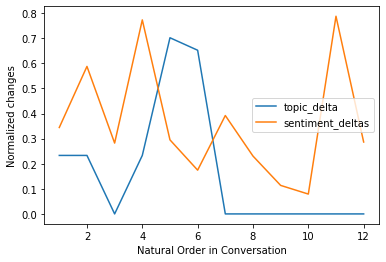

In [13]:
#from sklearn import preprocessing
print(topic2word.get(107))
print(topic2word.get(149))
print("delta is 0.23")

print(topic2word.get(149))
print(topic2word.get(8))
print("delta is 0.72")

sv = exampleconversation.sentiment_value
exampleconversation["sentiment_normalized"] = ((sv-sv.min())/(sv.max()-sv.min()))

exampleconversation["sentiment_deltas"] = exampleconversation["sentiment_normalized"].diff().abs()
plot = exampleconversation.plot(y=['topic_delta', "sentiment_deltas"], xlabel = "Natural Order in Conversation", ylabel="Normalized changes", use_index=True)
plot.get_figure().savefig('sentiment_topics.png')

After normalizing, it looks like we can compare the two metrics. However, topic continuation should be
interpreted differently then a continuous sentiment flow.

In order to compute the correlation we need to compute:
- a more precise sentiment classification
- a wider set of conversations with existing topic classifications
- a better metric of the topic flow that takes into account the general frequency of topic  changes and
  can thus highlight conversations with high or low topic volatility